Solve:
$$
    dX_t = \bigg[
        \frac{2}{1+t}X_t + (1+t)^2
    \bigg]dt + 
    (1+t)^2dW_t
$$ with the Chang scheme. 

As a comparison, we simulate $M=20$ batches each of $N=100$ sample paths, and vary time steps $\delta = \Delta = 2^{-1}, 2^{-2}, 2^{-3}, 2^{-4}$ up to $T = 0.5$.

The Ito SDE gives:
$$
    a(t,x) = \frac{2x}{1+t} + (1+t)^2, b(t) = (1+t)^2
$$ then the Stratonovich corrected drift is:
$$
    \underline{a}(t,x) = a(t,x)-\frac12b(t)b'(t) = \frac{2x}{1+t} + (1+t)^2 - \frac12\cdot (1+t)^2 \cdot 2(1+t) = \frac{2x}{1+t} + (1+t)^2 - (1+t)^3
$$

In [22]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt

# helper functions 
def a(t, x):
    return (2*x)/(1+t) + (1+t)**2
def b(t):
    return (1+t)**2
def b_prime(t):
    return 2*(1+t)
def a_strat(t, x):
    return a(t, x) - 0.5 * b(t) * b_prime(t)

# coefficients for computing multiple stochastic integral
def chang_onestep(tn, Yn, dt, p=15):
    # pre-generate all Gaussian r.v.s
    zeta1 = np.random.randn()
    xi1r = [np.random.randn() for _ in np.arange(1, p+1)]
    eta1r = [np.random.randn() for _ in np.arange(1, p+1)]
    mu1p = np.random.randn()
    phi1p = np.random.randn()
    # a_10
    r_inv = 1/np.arange(1, p+1)
    r2_inv = 1/(np.arange(1, p+1)**2)
    rhop = (1/12)-(1/(2*(np.pi**2)))*np.sum(r2_inv)
    a_10 = (-1/np.pi)*np.sqrt(2*dt)*np.sum(r_inv*xi1r)-2*np.sqrt(dt*rhop)*mu1p
    # b1
    r4_inv = 1/(np.arange(1, p+1)**4)
    alphap = (np.pi**2)/180 - (0.5/(np.pi**2))*np.sum(r4_inv)
    b_1 = np.sqrt(dt/2)*np.sum(r2_inv*eta1r)+np.sqrt(dt*alphap)*phi1p
    # C_p_11
    xi1l = [np.random.randn() for _ in np.arange(1, p+1)]
    eta1l = [np.random.randn() for _ in np.arange(1, p+1)]
    C_p_11 = 0
    for i in range(p):
        r = i + 1 # 1, ..., p
        for j in range(p):
            l = j + 1 # 1, ..., p
            if r != l:
                C_p_11 = C_p_11 + (r/(r**2-l**2))*((1/l)*xi1r[i]*xi1l[j]-(l/r)*eta1r[i]*eta1l[j])
    J_110p = (1/(3*2*1))*(dt**2)*(zeta1**2)+(1/4)*dt*(a_10**2)-(1/(2*np.pi))*(dt**(3/2))*zeta1*b_1 + \
                (1/4)*(dt**(3/2))*a_10*zeta1 - (dt**2)*C_p_11
    # compute Brownian increments
    dW = np.sqrt(dt)*zeta1
    dZ = 0.5*dt*(np.sqrt(dt)*zeta1+a_10)
    # take one step
    Ybar_plus = Yn+0.5*a_strat(tn, Yn)*dt+(1/dt)*b(tn)*(dZ+np.sqrt(np.abs(2*J_110p*dt-(dZ**2))))
    Ybar_minus = Yn+0.5*a_strat(tn, Yn)*dt+(1/dt)*b(tn)*(dZ-np.sqrt(np.abs(2*J_110p*dt-(dZ**2))))
    Ynp1 = Yn + 0.5*(a(tn+0.5*dt, Ybar_plus) + a(tn+0.5*dt, Ybar_minus))*dt \
        + b(tn)*dW + (1/dt)*(b(tn+dt)-b(tn))*(dW*dt-dZ)
    return Ynp1    
def chang_scheme(Y0, tgrid):
    dt = tgrid[1]-tgrid[0]
    Nt = len(tgrid)
    all_sol = np.zeros(Nt)
    all_sol[0] = Y0
    Yn = Y0
    for i in range(Nt-1):
        tn = tgrid[i]
        Yn = chang_onestep(tn, Yn, dt)
        all_sol[i+1] = Yn
    return all_sol

def chang_final_solution(Y0, tgrid):
    return chang_scheme(Y0, tgrid)[-1]

In [23]:
# number of batches
M = 20
# number of samples for each batch
N = 100
# all step sizes
all_dt = 2**np.array([-1., -2., -3., -4.])
# final time
T = 0.5
# initial condition
Y0 = 1
# store all solutions (only final solutions)
all_paths = np.zeros([M, N, len(all_dt)])
for i in range(len(all_dt)):
    dt = all_dt[i]
    tgrid = np.arange(0, T+dt, dt)
    Y0 = 1
    for idx1 in range(M):
        for idx2 in range(N):
            all_paths[idx1, idx2, i] = chang_final_solution(Y0, tgrid)

As a comparison, we simulate the exact solution using the above timesteps.
$$
    X_t = (1+t)^2(1+W_t+t)
$$ for $t=T=0.5$:
$$
    X_{T} = 2.25(W_T+1.5)
$$ where $W_T \sim \mathcal{N}(0, 0.5)$.

In [24]:
def exact_solution(Y0, tgrid):
    dt = tgrid[1]-tgrid[0]
    Nt = len(tgrid)
    # simulate Brownian motion
    dWt = np.sqrt(dt)*np.random.normal(loc=0, scale=1, size=Nt)
    Wt = np.cumsum(dWt)
    return (((1+tgrid)**2)*(1+Wt+tgrid))
def exact_final_solution(Y0, tgrid):
    return exact_solution(Y0, tgrid)[-1]

# number of batches
M = 20
# number of samples for each batch
N = 100
# all step sizes
all_dt = 2**np.array([-1., -2., -3., -4.])
# final time
T = 0.5
# initial condition
Y0 = 1
# store all solutions (only final solutions)
all_paths_exact = np.zeros([M, N, len(all_dt)])
for i in range(len(all_dt)):
    dt = all_dt[i]
    tgrid = np.arange(0, T+dt, dt)
    Y0 = 1
    for idx1 in range(M):
        for idx2 in range(N):
            all_paths_exact[idx1, idx2, i] = exact_final_solution(Y0, tgrid)

In [63]:
test = chang_scheme(1, np.arange(0, 0.5+0.0001, 0.0001))

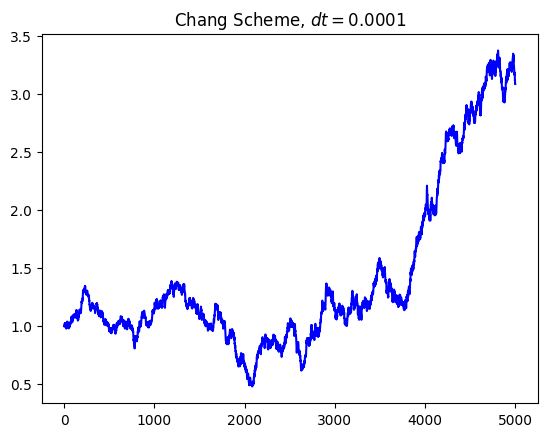

In [64]:
plt.plot(test, color='blue');
plt.title(r"Chang Scheme, $dt=0.0001$");

In [69]:
test2 = exact_solution(1, np.arange(0, 0.5+0.0001, 0.0001))

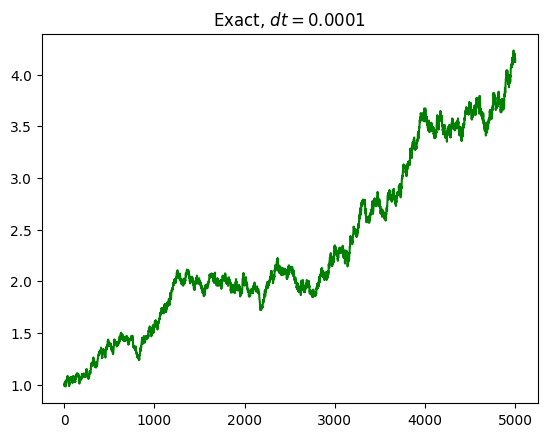

In [70]:
plt.plot(test2, color='green');
plt.title(r"Exact, $dt=0.0001$");